<a href="https://colab.research.google.com/github/ViniciusCastillo/BootcampAlura_ProjetoModulo5/blob/main/Notebooks/Seleciona_Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook para encontrar o melhor modelo de previsão das internação em UTI por Covid-19

O objetivo aqui é testar algumas combinações de pipeline contendo seleção de dados, reescala e modelo, tentando obter a melhor previsibilidade de internação em UTI, a partir do momento que uma paciente chega no hospital.

Os dados, as funções e classes utilizadas aqui foram criadas [neste outro notebook](https://github.com/ViniciusCastillo/BootcampAlura_ProjetoModulo5/blob/main/Notebooks/Bases_Funcoes_Classes.ipynb). Sendo que a origem dos dados vem do desafio no [Kaggle do Sírio Libanes](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

## Carregando notebook com os dados, funções e classes

In [1]:
!git clone "https://github.com/ViniciusCastillo/BootcampAlura_ProjetoModulo5" #clona o github para utilizarmos os arquivos

Cloning into 'BootcampAlura_ProjetoModulo5'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 38 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), done.


In [2]:
%run '/content/BootcampAlura_ProjetoModulo5/Notebooks/Bases_Funcoes_Classes.ipynb' #roda o arquivo com as funções e os dados

Tratamento da Base com Label Encoder

Removemos as linhas com ICU(UTI) igual a 1 e remarcamos a coluna com base no PATIENT_VISIT_IDENTIFIER que chegou na UTI
Distribuição de ICU na base tratada (%)
0.0    67.375887
1.0    32.624113
Name: ICU, dtype: float64

Ajustamos os valores continuos que estavam com Nam para o valor anterior ou posterior

Removemos as colunas que os valores são iguais para todas as linhas

As linhas ainda com Nam (5.0 linhas, 0.36% do total) foram eliminadas

O index foi resetado: RangeIndex(start=0, stop=1405, step=1)

Coluna com objeto categórico (AGE_PERCENTIL) foi transformada em numérica no DataFrame dados_LE.
Formato: (1405, 231)

Formato final do DataFrame dados_tratados: (1405, 231)
Tratamento da Base com One Hot Encoder

Trocamos o campo AGE_PERCENTIL pelos campos binários 10th, 20th, 30th, 40th, 50th, 60th, 70th, 80th, 90th, Above 90th

Formato final do DataFrame dados_OHE: (1405, 240)


## Encontrando o melhor pipeline para a janela de 0-2 horas
Irei separar essa frente por tipo de modelo utilizado e depois comparar o melhor de cada um para definir qual utilizar.

### Separando as bases para essa janela

In [8]:
dados_LE.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,0-2,1.0
1,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,2-4,1.0
2,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,-0.107143,0.736842,0.333333,-0.230769,-0.132075,-0.586207,-0.107143,0.736842,0.443299,0.0000,-0.025641,-0.500000,0.318681,0.898990,-0.076923,-0.459459,-0.313433,-0.636364,-0.275362,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,4-6,1.0
3,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,-0.107143,0.736842,0.333333,-0.230769,-0.132075,-0.586207,-0.107143,0.736842,0.443299,0.0000,-0.025641,-0.500000,0.318681,0.898990,-0.076923,-0.459459,-0.313433,-0.636364,-0.275362,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,6-12,1.0
4,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.6

In [16]:
# filtrando apenas a primeira janela de dados_LE
dados_LE_0_2 = dados_LE[dados_LE["WINDOW"] == '0-2']
# filtrando apenas a primeira janela de dados_OHE utilizando outro forma de fazer isso
dados_OHE_0_2 = dados_OHE.query("WINDOW == '0-2'")

### Utilizando Logistic Regression

Começando de forma bem ampla

*OBS: em testes anteriores, ter 2 metodos de seleção das variáveis a serem utilizadas se mostrou mais eficaz, com isso por padrão utilizo o método da classe **remove_corr** criada no outro notebook*

*OBS2: não estou utilizando o Normalizer porque em testes anteriores não se mostrou bom o suficiente e iria demorar muito para rodar com ele*

In [25]:
# cria um objeto com a classe de seleção do modelo
selecao_LR = seleciona_modelo(LogisticRegression(max_iter=6000))
# seleção dos parâmetros de teste para este modelo
testes  = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} 
# vamos começar os testes das demais funções do pipeline de forma bem ampla
selecao_LR.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE'),(dados_OHE_0_2,'OHE')],
                            lista_reescalas=['nenhuma',StandardScaler()],
                            selecao_menor=-100, selecao_maior=50, passo=50)

Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 1.0*mea

,base,reescala,roc_auc,desvio_padrao,inferior,superior,threshold,qtd_variaveis,solver
15,OHE,StandardScaler(),0.773070,0.044008,0.685054,0.861086,1.5*mean,32,saga
10,OHE,nenhuma,0.767990,0.040187,0.687616,0.848364,0.5*mean,59,newton-cg
14,OHE,nenhuma,0.791865,0.048159,0.695547,0.888184,1.5*mean,32,saga
12,OHE,nenhuma,0.789154,0.043363,0.702429,0.875880,1.0*mean,43,newton-cg
4,LE,nenhuma,0.793814,0.040492,0.712831,0.874797,1.0*mean,38,newton-cg


Os resultados apresentados acima são ordenados pelo limite inferior do intervalo de confiança, de forma que queremos buscar o modelo que tem menor probabilidade de erro, eu escolhi esse indicador como referência

Como esse era um teste inicial, esotu mais interessado em ver quais foram os piores resultados, com isso podes retirar alguns parâmetros dos teste e refinar outros antes de contiuar a busca pelo melhor modelo

In [26]:
selecao_LR.classifica_resultados().head(10)

,base,reescala,roc_auc,desvio_padrao,inferior,superior,threshold,qtd_variaveis,solver
1,LE,StandardScaler(),0.718107,0.072566,0.572976,0.863238,sem seleção adicional,103,sag
9,OHE,StandardScaler(),0.699273,0.057286,0.584701,0.813844,sem seleção adicional,111,liblinear
11,OHE,StandardScaler(),0.720686,0.046291,0.628103,0.813268,0.5*mean,59,liblinear
3,LE,StandardScaler(),0.746294,0.052111,0.642072,0.850515,0.5*mean,50,liblinear
5,LE,StandardScaler(),0.768319,0.058147,0.652025,0.884614,1.0*mean,38,liblinear
6,LE,nenhuma,0.779555,0.061501,0.656553,0.902556,1.5*mean,27,newton-cg
13,OHE,StandardScaler(),0.748877,0.044833,0.659210,0.838544,1.0*mean,43,sag
8,OHE,nenhuma,0.756515,0.047090,0.662335,0.850696,sem seleção adicional,111,lbfgs
7,LE,StandardScaler(),0.767631,0.049045,0.669541,0.865720,1.5*mean,27,liblinear
2,LE,nenhuma,0.774988,0.051607,0.671775,0.878201,0.5*mean,50,lbfgs


Olhando essa lista dos 10 piores, junto com a dos 5 melhores, consigo perceber que o **StandardScaler()** não está sendo muito útil, portanto irei **desconsidera-lo na próxima rodada**.

Outro ponto perceptível é que incluir o segundo modelo de seleção melhora o resultado, irei ajustar os parâmetors minimos e máximos dele para a próxima rodada.


In [27]:
selecao_LR.testa_parametros(testes,metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE'),(dados_OHE_0_2,'OHE')],
                            selecao_menor=-60, selecao_maior=90, passo=30)

Finalizada iteração: seleção - 0.4*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.7*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.3*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.9*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.4*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 0.7*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.3*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.9*mean, reescala - nenhuma, base - OHE


,base,reescala,roc_auc,desvio_padrao,inferior,superior,threshold,qtd_variaveis,solver
2,LE,nenhuma,0.791908,0.048309,0.695290,0.888525,1.0*mean,38,lbfgs
4,LE,nenhuma,0.784694,0.044347,0.696000,0.873388,1.6*mean,27,newton-cg
11,OHE,nenhuma,0.794619,0.048872,0.696876,0.892362,1.9*mean,23,newton-cg
10,OHE,nenhuma,0.795935,0.041209,0.713516,0.878353,1.6*mean,32,sag
9,OHE,nenhuma,0.796582,0.038656,0.719271,0.873894,1.3*mean,36,sag


In [28]:
selecao_LR.classifica_resultados().head(10)

,base,reescala,roc_auc,desvio_padrao,inferior,superior,threshold,qtd_variaveis,solver
3,LE,nenhuma,0.776317,0.048543,0.679231,0.873403,1.3*mean,31,lbfgs
7,OHE,nenhuma,0.781760,0.050859,0.680043,0.883477,0.7*mean,51,newton-cg
5,LE,nenhuma,0.778789,0.049089,0.680610,0.876967,1.9*mean,24,newton-cg
6,OHE,nenhuma,0.771348,0.045139,0.681070,0.861626,0.4*mean,60,lbfgs
0,LE,nenhuma,0.777885,0.048321,0.681243,0.874526,0.4*mean,52,lbfgs
8,OHE,nenhuma,0.785539,0.050044,0.685452,0.885626,1.0*mean,43,sag
1,LE,nenhuma,0.784368,0.047727,0.688914,0.879821,0.7*mean,44,newton-cg
2,LE,nenhuma,0.791908,0.048309,0.695290,0.888525,1.0*mean,38,lbfgs
4,LE,nenhuma,0.784694,0.044347,0.696000,0.873388,1.6*mean,27,newton-cg
11,OHE,nenhuma,0.794619,0.048872,0.696876,0.892362,1.9*mean,23,newton-cg


Dois pontos perceptívesi são que a base OHE tem tido uma perfomarnce melhor, bem como que o intervalo igual a média para cima na hora de seleção dos dados tem se portado melhor. 

Vamos fazer esses ajustes e também aumentar um pouco a repetição para evitar a oscilação que estamos vendo no resultado final.

In [29]:
selecao_LR.testa_parametros(testes,metrica='roc_auc', lista_dados=[(dados_OHE_0_2,'OHE')],
                            selecao_menor=0, selecao_maior=100, passo=10, n_repeats=15)

Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.1*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.2*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.3*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.4*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.7*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.8*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.9*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 2.0*mean, reescala - nenhuma, base - OHE


,base,reescala,roc_auc,desvio_padrao,inferior,superior,threshold,qtd_variaveis,solver
3,OHE,nenhuma,0.790999,0.045074,0.700852,0.881147,1.3*mean,36,newton-cg
9,OHE,nenhuma,0.790038,0.043262,0.703513,0.876563,1.9*mean,23,newton-cg
8,OHE,nenhuma,0.796842,0.045152,0.706537,0.887146,1.8*mean,26,newton-cg
10,OHE,nenhuma,0.793997,0.042270,0.709457,0.878536,2.0*mean,19,sag
6,OHE,nenhuma,0.793053,0.038119,0.716816,0.869291,1.6*mean,32,newton-cg


In [30]:
selecao_LR.classifica_resultados()

,base,reescala,roc_auc,desvio_padrao,inferior,superior,threshold,qtd_variaveis,solver
5,OHE,nenhuma,0.795323,0.056472,0.682379,0.908267,1.5*mean,33,newton-cg
1,OHE,nenhuma,0.788065,0.051959,0.684146,0.891983,1.1*mean,40,saga
0,OHE,nenhuma,0.788663,0.051407,0.685849,0.891476,1.0*mean,43,lbfgs
7,OHE,nenhuma,0.797260,0.055644,0.685972,0.908549,1.7*mean,27,lbfgs
4,OHE,nenhuma,0.795334,0.051565,0.692203,0.898465,1.4*mean,34,newton-cg
2,OHE,nenhuma,0.793692,0.050016,0.693660,0.893724,1.2*mean,36,newton-cg
3,OHE,nenhuma,0.790999,0.045074,0.700852,0.881147,1.3*mean,36,newton-cg
9,OHE,nenhuma,0.790038,0.043262,0.703513,0.876563,1.9*mean,23,newton-cg
8,OHE,nenhuma,0.796842,0.045152,0.706537,0.887146,1.8*mean,26,newton-cg
10,OHE,nenhuma,0.793997,0.042270,0.709457,0.878536,2.0*mean,19,sag


Vou fazer um último teste, mantendo apenas o modelo newton-cg que tem mostrado os melhores resultados, aumentando um pouco mais as repetições para reduzir o risco de oscilação do resultado. 
Também irei focar numa faixa mais entre 1,2 e 2 do ponto médio da seleção com um passo menor para buscar a melhor pipeline para este modelo de regressão logística

In [33]:
selecao_LR.testa_parametros({'solver': ['newton-cg']},metrica='roc_auc', lista_dados=[(dados_OHE_0_2,'OHE')],
                            selecao_menor=20, selecao_maior=100, passo=5, n_repeats=30)

Finalizada iteração: seleção - 1.2*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.25*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.3*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.35*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.4*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.45*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.55*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.6*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.65*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.7*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.75*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.8*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 1.85*mean, reescala - nenhu

,base,reescala,roc_auc,desvio_padrao,inferior,superior,threshold,qtd_variaveis,solver
1,OHE,nenhuma,0.792530,0.044805,0.702920,0.882141,1.25*mean,36,newton-cg
8,OHE,nenhuma,0.794443,0.045702,0.703039,0.885848,1.6*mean,32,newton-cg
13,OHE,nenhuma,0.796504,0.046157,0.704189,0.888819,1.85*mean,26,newton-cg
3,OHE,nenhuma,0.792756,0.044047,0.704663,0.880849,1.35*mean,35,newton-cg
11,OHE,nenhuma,0.795568,0.038848,0.717872,0.873264,1.75*mean,27,newton-cg


Após essa análise um pouco mais detalhada podemos criar o melhor pipeline com base no melhor resultado e também visualizar quais foram as 27 variáveis definidas como base para o modelo 

In [38]:
selecao_LR.cria_pipeline()
selecao_LR.resultados.loc[11,'selecionador'].get_feature_names_out()

array(['AGE_ABOVE65', 'GENDER', 'DISEASE GROUPING 1',
       'DISEASE GROUPING 4', 'HTN', 'ALBUMIN_MEDIAN', 'BIC_VENOUS_MEDIAN',
       'CALCIUM_MEDIAN', 'CREATININ_MEDIAN', 'GLUCOSE_MEDIAN',
       'LINFOCITOS_MEDIAN', 'PCR_MEDIAN', 'PLATELETS_MEDIAN',
       'SAT02_VENOUS_MEDIAN', 'SODIUM_MEDIAN',
       'BLOODPRESSURE_DIASTOLIC_MEAN', 'OXYGEN_SATURATION_MEAN',
       'BLOODPRESSURE_DIASTOLIC_MIN', 'BLOODPRESSURE_SISTOLIC_MAX',
       'OXYGEN_SATURATION_MAX', 'BLOODPRESSURE_DIASTOLIC_DIFF',
       'BLOODPRESSURE_SISTOLIC_DIFF', 'HEART_RATE_DIFF',
       'RESPIRATORY_RATE_DIFF', '10th', '60th', 'Above 90th'],
      dtype=object)

Podemos também verificar o resultado desse modelo contra uma base de teste aleatória. Porém para comparação continuarei olhando o resultado anterior, olhando o limite inferior do intervalo de confiança.

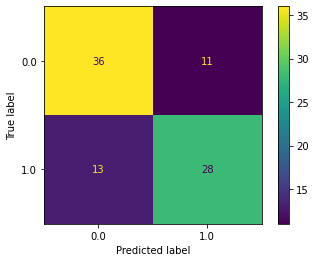


               precision    recall  f1-score   support

         0.0       0.73      0.77      0.75        47
         1.0       0.72      0.68      0.70        41

    accuracy                           0.73        88
   macro avg       0.73      0.72      0.72        88
weighted avg       0.73      0.73      0.73        88

ROC AUC: 78.10%


In [40]:
selecao_LR.roda_pipeline_metricas(random_state=23489)

### Utilizando Randon Forest

Como no anterior, começaremos de uma forma mais ampla até achar o modelo mais preciso. Por este modelo ser mais parametrizável, talvez seja necessário mais etapas.


In [42]:
# cria um objeto com a classe de seleção do modelo
selecao_RF = seleciona_modelo(RandomForestClassifier())
# seleção dos parâmetros de teste para este modelo
testes  = {'n_estimators': [10, 100, 200],
           'max_depth': [5, 10, 15],
           'criterion': ['gini', 'entropy']}
# vamos começar os testes das demais funções do pipeline de forma bem ampla
selecao_RF.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE'),(dados_OHE_0_2,'OHE')],
                            lista_reescalas=['nenhuma',StandardScaler()],
                            selecao_menor=-100, selecao_maior=50, passo=50)

Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 1.0*mea

,base,reescala,roc_auc,desvio_padrao,inferior,superior,threshold,qtd_variaveis,criterion,max_depth,n_estimators
8,OHE,nenhuma,0.800887,0.040370,0.720148,0.881627,sem seleção adicional,111,entropy,10,200
2,LE,nenhuma,0.805854,0.042742,0.720371,0.891337,0.5*mean,51,entropy,10,200
1,LE,StandardScaler(),0.802070,0.040667,0.720737,0.883403,sem seleção adicional,103,entropy,10,200
5,LE,StandardScaler(),0.807518,0.042668,0.722181,0.892854,1.0*mean,42,gini,10,200
0,LE,nenhuma,0.805335,0.039844,0.725646,0.885024,sem seleção adicional,103,entropy,10,200


In [43]:
selecao_RF.classifica_resultados().head(10)

,base,reescala,roc_auc,desvio_padrao,inferior,superior,threshold,qtd_variaveis,criterion,max_depth,n_estimators
15,OHE,StandardScaler(),0.790114,0.049937,0.690240,0.889989,1.5*mean,35,gini,5,200
10,OHE,nenhuma,0.795811,0.051843,0.692126,0.899497,0.5*mean,51,gini,5,200
13,OHE,StandardScaler(),0.800184,0.052993,0.694199,0.906170,1.0*mean,44,entropy,10,200
9,OHE,StandardScaler(),0.793938,0.045920,0.702098,0.885777,sem seleção adicional,111,gini,10,200
14,OHE,nenhuma,0.789763,0.043331,0.703101,0.876425,1.5*mean,35,entropy,10,200
4,LE,nenhuma,0.808390,0.050892,0.706607,0.910173,1.0*mean,42,gini,10,200
6,LE,nenhuma,0.802669,0.047057,0.708554,0.896783,1.5*mean,31,gini,10,200
11,OHE,StandardScaler(),0.800519,0.044373,0.711773,0.889266,0.5*mean,51,entropy,10,200
12,OHE,nenhuma,0.799517,0.041824,0.715870,0.883165,1.0*mean,44,gini,10,200
3,LE,StandardScaler(),0.806355,0.044019,0.718317,0.894392,0.5*mean,51,gini,10,200


Nesta primeira roda percebo que o critério 'gini' tem um resultado pior, e será desconsiderado na próxima rodada.

Outro ponto que podemos perceber é que quanto mais estimators, melhor o resultado, como não pretendo aumentar mais este valor, já vou deixa-lo travado em 200

In [48]:
testes  = {'n_estimators': [200],
           'max_depth': [5, 10, 15],
           'criterion': ['entropy']}
selecao_RF.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE'),(dados_OHE_0_2,'OHE')],
                            lista_reescalas=['nenhuma',StandardScaler()],
                            selecao_menor=-100, selecao_maior=50, passo=50)

Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - OHE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - OHE
Finalizada iteração: seleção - 1.0*mea

,base,reescala,roc_auc,desvio_padrao,inferior,superior,threshold,qtd_variaveis,criterion,max_depth,n_estimators
3,LE,StandardScaler(),0.803050,0.043196,0.716658,0.889442,0.5*mean,50,entropy,10,200
4,LE,nenhuma,0.805190,0.043245,0.718700,0.891680,1.0*mean,45,entropy,10,200
1,LE,StandardScaler(),0.803035,0.039690,0.723655,0.882415,sem seleção adicional,103,entropy,10,200
7,LE,StandardScaler(),0.802889,0.038830,0.725229,0.880549,1.5*mean,33,entropy,5,200
6,LE,nenhuma,0.803680,0.038367,0.726946,0.880414,1.5*mean,33,entropy,10,200


In [49]:
selecao_RF.classifica_resultados().head(10)

,base,reescala,roc_auc,desvio_padrao,inferior,superior,threshold,qtd_variaveis,criterion,max_depth,n_estimators
15,OHE,StandardScaler(),0.788317,0.057692,0.672933,0.903700,1.5*mean,33,entropy,5,200
9,OHE,StandardScaler(),0.799334,0.053914,0.691506,0.907162,sem seleção adicional,111,entropy,15,200
5,LE,StandardScaler(),0.799615,0.052038,0.695539,0.903691,1.0*mean,45,entropy,10,200
8,OHE,nenhuma,0.800974,0.051601,0.697772,0.904177,sem seleção adicional,111,entropy,10,200
13,OHE,StandardScaler(),0.794891,0.048230,0.698430,0.891351,1.0*mean,47,entropy,10,200
12,OHE,nenhuma,0.796023,0.047820,0.700383,0.891664,1.0*mean,47,entropy,15,200
10,OHE,nenhuma,0.793867,0.045483,0.702901,0.884833,0.5*mean,52,entropy,10,200
14,OHE,nenhuma,0.791821,0.042983,0.705856,0.877787,1.5*mean,33,entropy,10,200
0,LE,nenhuma,0.801548,0.046364,0.708821,0.894276,sem seleção adicional,103,entropy,15,200
11,OHE,StandardScaler(),0.797057,0.042726,0.711605,0.882510,0.5*mean,52,entropy,10,200


Podemos observar que a base LE está trazendo resultados melhores, podemos fazer essa seleção da próxima vez. E como estamos tendo muitas variações no resultado tentarei aumentar um pouco o número de repetições

In [51]:
selecao_RF.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE')],
                            lista_reescalas=['nenhuma',StandardScaler()],
                            selecao_menor=-100, selecao_maior=50, passo=50, n_repeats=15)

Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - sem seleção adicional, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.0*mean, reescala - StandardScaler(), base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 1.5*mean, reescala - StandardScaler(), base - LE


,base,reescala,roc_auc,desvio_padrao,inferior,superior,threshold,qtd_variaveis,criterion,max_depth,n_estimators
6,LE,nenhuma,0.801039,0.051687,0.697665,0.904413,1.5*mean,34,entropy,5,200
0,LE,nenhuma,0.804572,0.052460,0.699653,0.909491,sem seleção adicional,103,entropy,10,200
5,LE,StandardScaler(),0.804131,0.051654,0.700823,0.907439,1.0*mean,43,entropy,5,200
4,LE,nenhuma,0.800056,0.049538,0.700979,0.899132,1.0*mean,43,entropy,5,200
1,LE,StandardScaler(),0.804689,0.045742,0.713206,0.896172,sem seleção adicional,103,entropy,5,200


In [53]:
selecao_RF.classifica_resultados().head(10)

,base,reescala,roc_auc,desvio_padrao,inferior,superior,threshold,qtd_variaveis,criterion,max_depth,n_estimators
2,LE,nenhuma,0.797821,0.052308,0.693206,0.902437,0.5*mean,51,entropy,10,200
3,LE,StandardScaler(),0.798003,0.051364,0.695276,0.900731,0.5*mean,51,entropy,15,200
7,LE,StandardScaler(),0.800101,0.051761,0.696579,0.903623,1.5*mean,34,entropy,10,200
6,LE,nenhuma,0.801039,0.051687,0.697665,0.904413,1.5*mean,34,entropy,5,200
0,LE,nenhuma,0.804572,0.052460,0.699653,0.909491,sem seleção adicional,103,entropy,10,200
5,LE,StandardScaler(),0.804131,0.051654,0.700823,0.907439,1.0*mean,43,entropy,5,200
4,LE,nenhuma,0.800056,0.049538,0.700979,0.899132,1.0*mean,43,entropy,5,200
1,LE,StandardScaler(),0.804689,0.045742,0.713206,0.896172,sem seleção adicional,103,entropy,5,200


Como não estou vendo uma diferença relevante entre o StandardScaler e não fazer nada, até porque os nossos dados aparentavam já estar tradados, irei remove-lo.

Outro ponto que irei trabalhar melhor é que o max_depth de 15 não tem gerado valor, irei rever o intevarlo para ver se obtenho resultados melhores com outros parametros

In [54]:
testes  = {'n_estimators': [200],
           'max_depth': [4, 6, 8, 10, 12],
           'criterion': ['entropy']}
selecao_RF.testa_parametros(testes, metrica='roc_auc', lista_dados=[(dados_LE_0_2,'LE')],
                            selecao_menor=-100, selecao_maior=50, passo=50, n_repeats=15)

Finalizada iteração: seleção - sem seleção adicional, reescala - nenhuma, base - LE
Finalizada iteração: seleção - 0.5*mean, reescala - nenhuma, base - LE


KeyboardInterrupt: ignored